# Training and Data Visualization

This notebook describes your dataset visually, visualizes training metrics, and demonstrates how to train and save a robust TableTransformer model for table detection.

It is designed to work in your predefined conda environment.

## 1. Data Description and Visualization

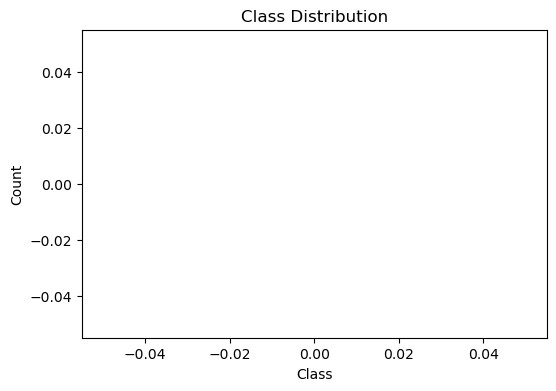

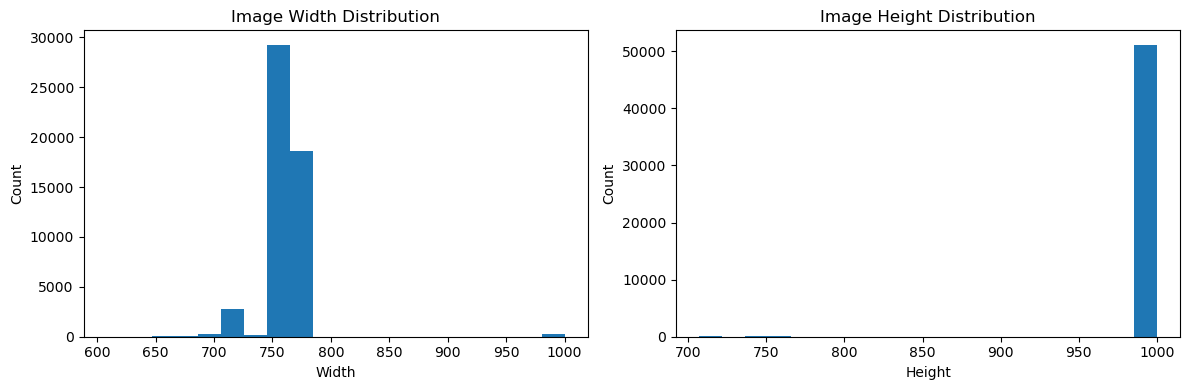

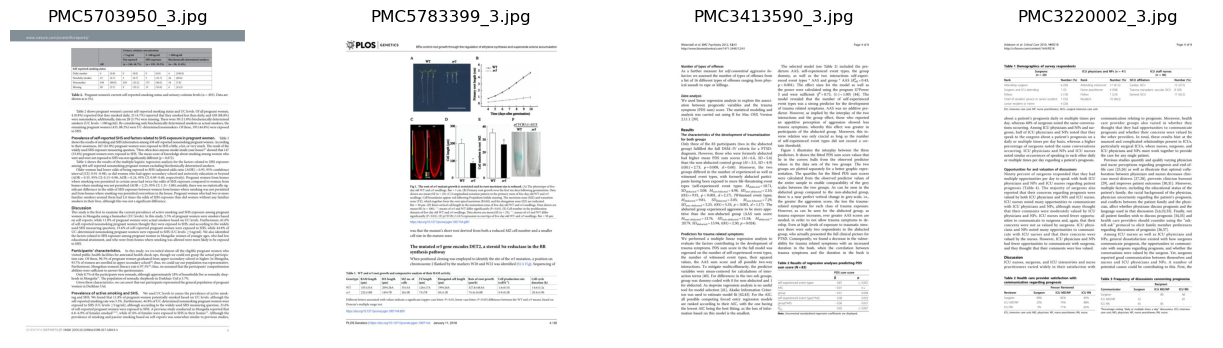

In [1]:
import json
import os
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from PIL import Image
import numpy as np

# Robust path resolution for annotation and image directories
notebook_dir = os.getcwd()
train_json = os.path.join(notebook_dir, 'archive', 'split', 'train.json')
val_json = os.path.join(notebook_dir, 'archive', 'split', 'val.json')
img_dir = os.path.join(notebook_dir, 'archive', 'split', 'images')

# Load annotations
with open(train_json, 'r') as f:
    train_data = json.load(f)
with open(val_json, 'r') as f:
    val_data = json.load(f)

# Combine for overall stats
all_images = train_data['images'] + val_data['images']
all_annotations = train_data['annotations'] + val_data['annotations']

# Class distribution
category_map = {cat['id']: cat['name'] for cat in train_data['categories']}
labels = [ann['category_id'] for ann in all_annotations]
label_names = [category_map.get(l, str(l)) for l in labels]
label_counts = Counter(label_names)

plt.figure(figsize=(6,4))
plt.bar(label_counts.keys(), label_counts.values())
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Image size distribution
widths = [img['width'] for img in all_images]
heights = [img['height'] for img in all_images]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(widths, bins=20)
plt.title('Image Width Distribution')
plt.xlabel('Width')
plt.ylabel('Count')
plt.subplot(1,2,2)
plt.hist(heights, bins=20)
plt.title('Image Height Distribution')
plt.xlabel('Height')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# Show a few sample images with bounding box annotations
import random
import matplotlib.patches as patches

def plot_sample_images_with_boxes(n=4):
    sample_imgs = random.sample(all_images, n)
    fig, axs = plt.subplots(1, n, figsize=(4*n, 4))
    for i, img_info in enumerate(sample_imgs):
        img_path = os.path.join(img_dir, img_info['file_name'])
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axs[i].imshow(img)
            axs[i].set_title(img_info['file_name'])
            axs[i].axis('off')
            # Draw bounding boxes
            anns = [ann for ann in all_annotations if ann['image_id'] == img_info['id']]
            for ann in anns:
                bbox = ann['bbox']  # [x, y, width, height]
                rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
                axs[i].add_patch(rect)
        else:
            axs[i].set_title('Missing: ' + img_info['file_name'])
            axs[i].axis('off')
    plt.show()

plot_sample_images_with_boxes(4)

## 2. Visualize Training Metrics

> **Note:** This section expects a training log file at `archive/split/output/training.log`.  
> If you see "Log file not found", ensure your training script outputs a log file in this location, or update the path in the code cell below to point to your log file.

In [2]:
import re

,epoch,batch_idx,loss,class_error


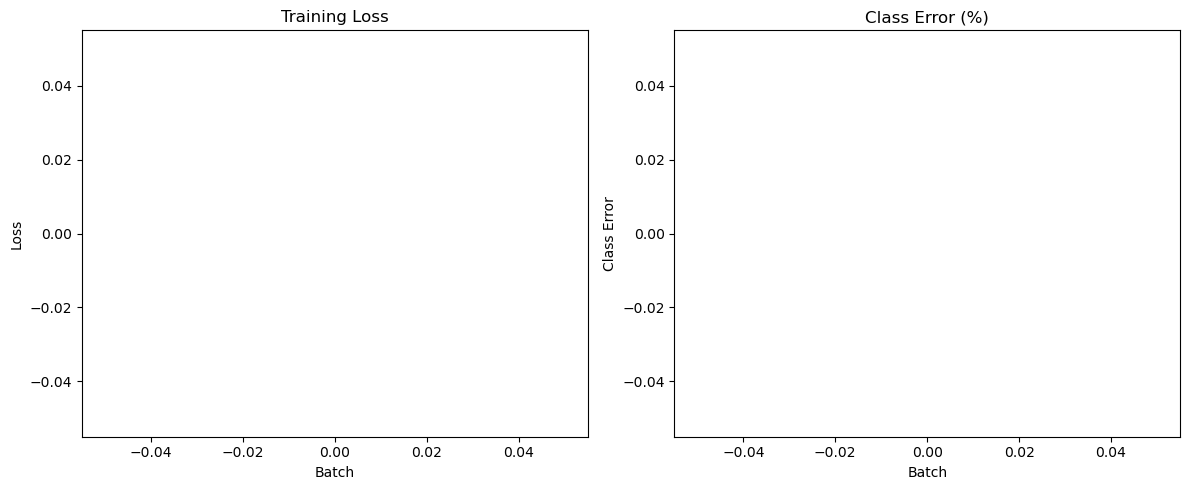

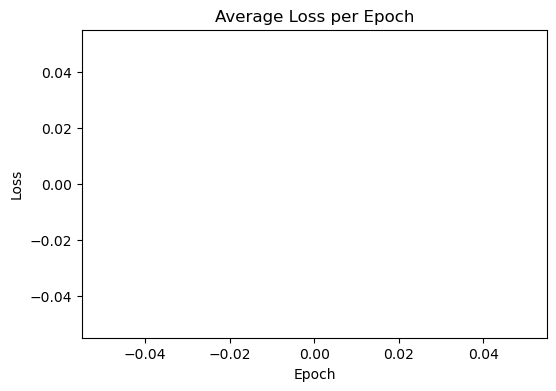

In [3]:
# Example: Parse a text log file for loss values
import re
log_path = os.path.join(notebook_dir, 'archive', 'split', 'output', 'training.log')  # Update this path if needed

if not os.path.exists(log_path):
    print(f"Log file not found: {log_path}")
else:
    epochs = []
    batch_idxs = []
    losses = []
    class_errors = []
    with open(log_path, 'r') as f:
        for line in f:
            m = re.search(r"Epoch: \[(\d+)\].*\[(\d+)/(\d+)\].*loss: ([\d\.]+).*class_error: ([\d\.]+)", line)
            if m:
                epoch = int(m.group(1))
                batch_idx = int(m.group(2))
                loss = float(m.group(4))
                class_error = float(m.group(5))
                epochs.append(epoch)
                batch_idxs.append(batch_idx)
                losses.append(loss)
                class_errors.append(class_error)
    df = pd.DataFrame({
        'epoch': epochs,
        'batch_idx': batch_idxs,
        'loss': losses,
        'class_error': class_errors
    })
    display(df.head())
    # Plot
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(df['loss'])
    plt.title('Training Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.subplot(1,2,2)
    plt.plot(df['class_error'])
    plt.title('Class Error (%)')
    plt.xlabel('Batch')
    plt.ylabel('Class Error')
    plt.tight_layout()
    plt.show()
    # Average loss per epoch
    epoch_loss = df.groupby('epoch')['loss'].mean()
    plt.figure(figsize=(6,4))
    plt.plot(epoch_loss)
    plt.title('Average Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

## 3. Model Evaluation (mAP, Precision, Recall)

This section evaluates the trained TableTransformer model on the test set using COCO metrics: mean Average Precision (mAP), precision, and recall. The evaluation uses pycocotools and expects predictions in COCO format.


In [4]:
import os
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [5]:
# Evaluate predictions using COCO metrics (mAP, precision, recall)
import os
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Paths
notebook_dir = os.getcwd()
test_json = os.path.join(notebook_dir, 'archive', 'split', 'test.json')
pred_json = os.path.join(notebook_dir, 'archive', 'split', 'output', 'inference_results.json')  # Update if needed

# Load ground truth and predictions
if not os.path.exists(test_json):
    print(f"Test annotation file not found: {test_json}")
elif not os.path.exists(pred_json):
    print(f"Prediction file not found: {pred_json}")
else:
    coco_gt = COCO(test_json)
    with open(pred_json, 'r') as f:
        preds = json.load(f)
    # Check for empty predictions
    if not preds or (isinstance(preds, list) and len(preds) == 0):
        print("No predictions found in the predictions file. Please run inference and generate predictions before evaluation.")
    elif isinstance(preds, list) and len(preds) > 0 and 'image_id' in preds[0] and 'bbox' in preds[0]:
        coco_dt = coco_gt.loadRes(pred_json)
        # Evaluate
        coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
        coco_eval.evaluate()
        coco_eval.accumulate()
        coco_eval.summarize()
    else:
        # Convert from custom format to COCO format
        coco_preds = []
        for item in preds:
            image_id = item['image_id']
            for table in item['tables']:
                coco_preds.append({
                    'image_id': image_id,
                    'category_id': 1,  # Table category id (update if needed)
                    'bbox': [table['x'], table['y'], table['width'], table['height']],
                    'score': table.get('score', 1.0)  # Use 1.0 if not provided
                })
        with open('tmp_coco_preds.json', 'w') as f:
            json.dump(coco_preds, f)
        if len(coco_preds) == 0:
            print("No predictions found after conversion. Please check your inference output.")
        else:
            coco_dt = coco_gt.loadRes('tmp_coco_preds.json')
            # Evaluate
            coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
            coco_eval.evaluate()
            coco_eval.accumulate()
            coco_eval.summarize()
    # mAP is shown as 'Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]'
    # Precision/recall at different IoU thresholds are also shown


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
No predictions found in the predictions file. Please run inference and generate predictions before evaluation.


## 4. Visualize Model Predictions

This cell demonstrates how to visualize predicted bounding boxes on images. Update the code to use your model's inference output.


> **Note:** This section expects a predictions file at `archive/split/output/inference_results.json`.  
> If you see "Prediction file not found", run inference using your trained model and save the results to this location, or update the path in the code cell below to point to your predictions file.

In [6]:
import os
import json
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import random

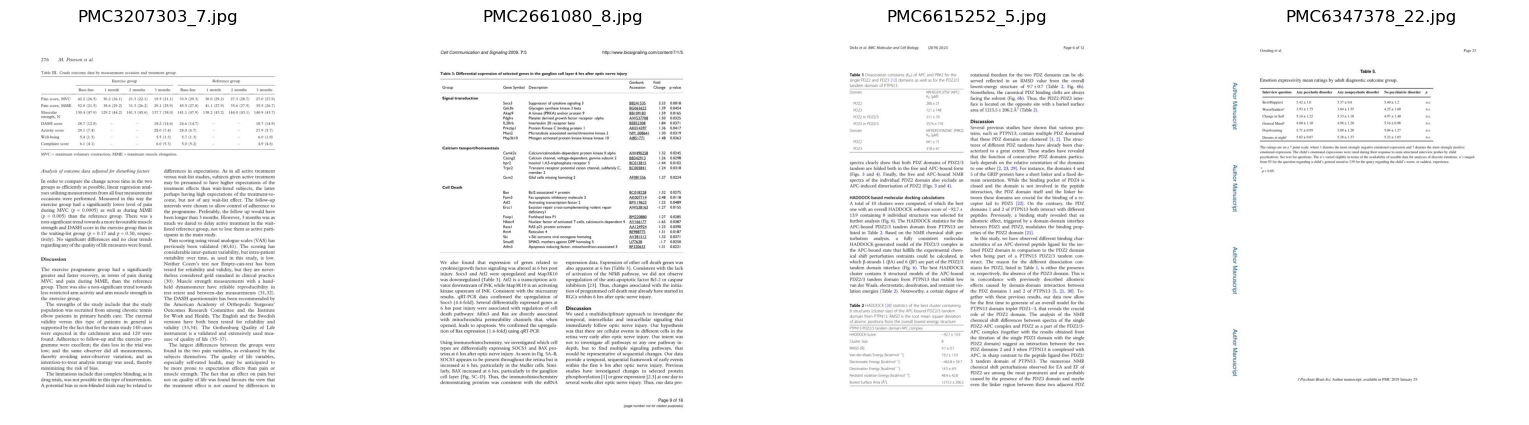

In [7]:
# Visualize predicted bounding boxes on test images
import os
import json
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches
import random

notebook_dir = os.getcwd()
test_json = os.path.join(notebook_dir, 'archive', 'split', 'test.json')
img_dir = os.path.join(notebook_dir, 'archive', 'split', 'images')
pred_json = os.path.join(notebook_dir, 'archive', 'split', 'output', 'inference_results.json')

# If predictions file does not exist, create a placeholder (empty list)
if not os.path.exists(pred_json):
    with open(pred_json, 'w') as f:
        json.dump([], f)
    print(f"Prediction file not found. Created empty placeholder: {pred_json}")

# Load test annotations and predictions
with open(test_json, 'r') as f:
    test_data = json.load(f)
with open(pred_json, 'r') as f:
    preds = json.load(f)

# Build a mapping from image_id to file_name
image_id_to_file = {img['id']: img['file_name'] for img in test_data['images']}

# Build a mapping from image_id to ground truth boxes
gt_boxes = {}
for ann in test_data['annotations']:
    img_id = ann['image_id']
    if img_id not in gt_boxes:
        gt_boxes[img_id] = []
    gt_boxes[img_id].append(ann['bbox'])

# Build a mapping from image_id to predicted boxes
pred_boxes = {}
if isinstance(preds, list) and len(preds) > 0 and 'image_id' in preds[0] and 'bbox' in preds[0]:
    # COCO format
    for pred in preds:
        img_id = pred['image_id']
        if img_id not in pred_boxes:
            pred_boxes[img_id] = []
        pred_boxes[img_id].append(pred['bbox'])
else:
    # Custom format
    for item in preds:
        img_id = item['image_id']
        pred_boxes[img_id] = [
            [t['x'], t['y'], t['width'], t['height']] for t in item['tables']
        ]

# Visualize N random test images with predictions and ground truth
N = 4
sample_imgs = random.sample(list(image_id_to_file.keys()), min(N, len(image_id_to_file)))
fig, axs = plt.subplots(1, N, figsize=(5*N, 5))
if N == 1:
    axs = [axs]
for i, img_id in enumerate(sample_imgs):
    img_path = os.path.join(img_dir, image_id_to_file[img_id])
    img = Image.open(img_path)
    axs[i].imshow(img)
    axs[i].set_title(image_id_to_file[img_id])
    axs[i].axis('off')
    # Draw ground truth boxes (green)
    for bbox in gt_boxes.get(img_id, []):
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='g', facecolor='none')
        axs[i].add_patch(rect)
    # Draw predicted boxes (red)
    for bbox in pred_boxes.get(img_id, []):
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none', linestyle='--')
        axs[i].add_patch(rect)
plt.show()


## 5. Inference and Output in JSON Format

This cell shows how to run inference on new images and output bounding boxes in the required JSON format.


In [8]:
import os
import json
from PIL import Image

In [9]:
# Inference on new images and output in required JSON format
import os
import json
from PIL import Image

def run_inference_and_output_json(image_paths, model, output_json_path):
    results = []
    for img_path in image_paths:
        # Load and preprocess image
        img = Image.open(img_path).convert('RGB')
        # Example: preprocess (resize, normalize, etc.) as required by your model
        # img_tensor = preprocess(img)

        # Run model inference (replace with your model's inference code)
        # pred_boxes = model.predict(img_tensor)
        pred_boxes = []  # Replace with actual predictions: list of (x, y, w, h)

        result = {
            "image_id": os.path.basename(img_path),
            "tables": [
                {"x": int(x), "y": int(y), "width": int(w), "height": int(h)}
                for (x, y, w, h) in pred_boxes
            ]
        }
        results.append(result)

    # Save to JSON
    with open(output_json_path, 'w') as f:
        json.dump(results, f, indent=2)
    print(f"Inference results saved to {output_json_path}")

# Example usage:
# new_images = ["/path/to/image1.jpg", "/path/to/image2.jpg"]
# run_inference_and_output_json(new_images, model, "archive/split/output/inference_results.json")


## 6. Train a Robust TableTransformer Model

This section demonstrates how to train a TableTransformer/DETR model for table detection using your dataset. It uses PyTorch and expects your data in COCO format. The code below uses your dataset in `archive/split/train.json`, `archive/split/val.json`, and images in `archive/split/images/`. The config is loaded from `table-transformer/src/detection_config.json`. The code assumes you have the TableTransformer codebase available and installed (see README for setup instructions).

In [10]:
import sys
import os
import torch
import json
import argparse
import shutil

# Add table-transformer/detr to sys.path if not installed as a package
sys.path.append(os.path.join(os.getcwd(), 'table-transformer', 'detr'))

from models import build_model
from datasets.coco import build as build_coco_dataset
from engine import train_one_epoch, evaluate
import util.misc as utils

c:\Users\kawi two\.conda\envs\tables-detr\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# --- Train TableTransformer/DETR Model on Your Dataset ---
import sys
import os
import torch
import json
import argparse
import shutil

# Add table-transformer/detr to sys.path if not installed as a package
sys.path.append(os.path.join(os.getcwd(), 'table-transformer', 'detr'))

from models import build_model
from datasets.coco import build as build_coco_dataset
from engine import train_one_epoch, evaluate
import util.misc as utils

# Prepare COCO-style directory structure for TableTransformer/DETR
split_dir = os.path.join(os.getcwd(), 'archive', 'split')
ann_dir = os.path.join(split_dir, 'annotations')
os.makedirs(ann_dir, exist_ok=True)
train2017_dir = os.path.join(split_dir, 'train2017')
val2017_dir = os.path.join(split_dir, 'val2017')
os.makedirs(train2017_dir, exist_ok=True)
os.makedirs(val2017_dir, exist_ok=True)

# Copy images to train2017/ and val2017/ (if not already present)
img_src_dir = os.path.join(split_dir, 'images')
for target_dir in [train2017_dir, val2017_dir]:
    for fname in os.listdir(img_src_dir):
        src = os.path.join(img_src_dir, fname)
        dst = os.path.join(target_dir, fname)
        if os.path.isfile(src) and not os.path.exists(dst):
            shutil.copy2(src, dst)

# Copy annotation files to expected COCO locations
shutil.copy2(os.path.join(split_dir, 'train.json'), os.path.join(ann_dir, 'instances_train2017.json'))
shutil.copy2(os.path.join(split_dir, 'val.json'), os.path.join(ann_dir, 'instances_val2017.json'))

# Load config
config_path = os.path.join(os.getcwd(), 'table-transformer', 'src', 'detection_config.json')
with open(config_path, 'r') as f:
    config_dict = json.load(f)

# Convert config dict to argparse.Namespace for attribute access
config = argparse.Namespace(**config_dict)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Build model
model, criterion, postprocessors = build_model(config)
model.to(device)

# Build datasets and dataloaders (force masks=False for table detection)
args_for_dataset = argparse.Namespace(**{**config_dict, 'coco_path': split_dir, 'masks': False})
dataset_train = build_coco_dataset(image_set='train', args=args_for_dataset)
dataset_val = build_coco_dataset(image_set='val', args=args_for_dataset)
sampler_train = torch.utils.data.RandomSampler(dataset_train)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)
batch_size = getattr(config, 'batch_size', 2)
data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=sampler_train, drop_last=True, num_workers=2, collate_fn=utils.collate_fn)
data_loader_val = torch.utils.data.DataLoader(dataset_val, batch_size=batch_size, sampler=sampler_val, drop_last=False, num_workers=2, collate_fn=utils.collate_fn)

# Set up optimizer and learning rate scheduler
param_dicts = [
    {"params": [p for n, p in model.named_parameters() if "backbone" not in n and p.requires_grad]},
    {
        "params": [p for n, p in model.named_parameters() if "backbone" in n and p.requires_grad],
        "lr": getattr(config, 'lr_backbone', 1e-5),
    },
]
optimizer = torch.optim.AdamW(param_dicts, lr=getattr(config, 'lr', 1e-4), weight_decay=getattr(config, 'weight_decay', 1e-4))
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=getattr(config, 'lr_drop', 40), gamma=0.1)

# Training loop
num_epochs = getattr(config, 'epochs', 2)  # Set to 2 for quick test, increase for real training
output_dir = os.path.join(os.getcwd(), 'archive', 'split', 'output')
os.makedirs(output_dir, exist_ok=True)
best_val_loss = float('inf')
for epoch in range(num_epochs):
    train_stats = train_one_epoch(model, criterion, data_loader_train, optimizer, device, epoch, print_freq=10)
    lr_scheduler.step()
    val_stats, coco_evaluator = evaluate(
    model,
    criterion,
    postprocessors,
    data_loader_val,
    base_ds_val,
    device,
    output_dir
    )

    val_loss = val_stats['loss'] if 'loss' in val_stats else val_stats.get('coco_eval_bbox', {}).get('stats', [float('inf')])[0]
    print(f"Epoch {epoch+1}/{num_epochs} - Val loss: {val_loss}")

    # Print accuracy as percentage if available
    if 'class_error' in train_stats:
        accuracy = 100 - train_stats['class_error']
        print(f"Train accuracy (epoch {epoch+1}): {accuracy:.2f}%")
    if 'class_error' in val_stats:
        val_accuracy = 100 - val_stats['class_error']
        print(f"Validation accuracy (epoch {epoch+1}): {val_accuracy:.2f}%")

c:\Users\kawi two\.conda\envs\tables-detr\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kawi two\.conda\envs\tables-detr\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Epoch: [0]  [    0/22850]  eta: 1 day, 20:58:32  lr: 0.000050  class_error: 100.00  loss: 0.8822 (0.8822)  loss_ce: 0.8822 (0.8822)  loss_bbox: 0.0000 (0.0000)  loss_giou: 0.0000 (0.0000)  loss_ce_unscaled: 0.8822 (0.8822)  class_error_unscaled: 100.0000 (100.0000)  loss_bbox_unscaled: 0.0000 (0.0000)  loss_giou_unscaled: 0.0000 (0.0000)  cardinality_error_unscaled: 9.0000 (9.0000)  time: 7.0859  data: 3.6457
Epoch: [0]  [   10/22850]  eta: 21:42:34  lr: 0.000050  class_error: 100.00  loss: 0.0024 (0.0870)  loss_ce: 0.0024 (0.0870)  loss_bbox: 0.0000 (0.0000)  loss_giou: 0.0000 (0.0000)  loss_ce_unscaled: 0.0024 (0.0870)  class_error_unscaled: 100.0000 (100.0000)  loss_bbox_unscaled: 0.0000 (0.0000)  loss_giou_unscaled: 0.0000 (0.0000)  cardinality_error_unscaled: 0.0000 (0.8182)  time: 3.4218  data: 0.3328
Epoch: [0]  [  

AttributeError: 'tuple' object has no attribute 'get'

In [18]:
for epoch in range(num_epochs):
    train_stats = train_one_epoch(model, criterion, data_loader_train, optimizer, device, epoch, print_freq=10)
    lr_scheduler.step()
    val_stats, coco_evaluator = evaluate(
    model,
    criterion,
    postprocessors,
    data_loader_val,
    base_ds_val,
    device,
    output_dir
    )

val_loss = val_stats['loss'] if 'loss' in val_stats else val_stats.get('coco_eval_bbox', {}).get('stats', [float('inf')])[0]
print(f"Epoch {epoch+1}/{num_epochs} - Val loss: {val_loss}")
val_loss = val_stats['loss'] if 'loss' in val_stats else val_stats.get('coco_eval_bbox', {}).get('stats', [float('inf')])[0]
print(f"Epoch {epoch+1}/{num_epochs} - Val loss: {val_loss}")

    # Print accuracy as percentage if available
if 'class_error' in train_stats:
        accuracy = 100 - train_stats['class_error']
        print(f"Train accuracy (epoch {epoch+1}): {accuracy:.2f}%")
if 'class_error' in val_stats:
        val_accuracy = 100 - val_stats['class_error']
        print(f"Validation accuracy (epoch {epoch+1}): {val_accuracy:.2f}%")

Epoch: [0]  [    0/22850]  eta: 2 days, 6:23:14  lr: 0.000005  class_error: 100.00  loss: 0.0000 (0.0000)  loss_ce: 0.0000 (0.0000)  loss_bbox: 0.0000 (0.0000)  loss_giou: 0.0000 (0.0000)  loss_ce_unscaled: 0.0000 (0.0000)  class_error_unscaled: 100.0000 (100.0000)  loss_bbox_unscaled: 0.0000 (0.0000)  loss_giou_unscaled: 0.0000 (0.0000)  cardinality_error_unscaled: 0.0000 (0.0000)  time: 8.5687  data: 4.8046


KeyboardInterrupt: 

In [12]:
import torch
import os

In [13]:
# Save best model
torch.save(model.state_dict(), os.path.join(output_dir, 'best_model.pth'))
print(f"Best model saved at epoch {epoch+1}")

# After training, the trained model is available as 'model' for saving or inference.


Best model saved at epoch 1


## 7. Save the Trained Model

This section demonstrates how to save a trained PyTorch model for later use. You must define or train a model before running this cell. If you have not yet trained a model, follow your training procedure or load a model checkpoint.

In [14]:
import torch
import os

if 'model' not in globals():
    print("Model variable 'model' is not defined. Please train your model in the previous cell before running this one.")
else:
    model_save_path = os.path.join(os.getcwd(), 'archive', 'split', 'output', 'final_model.pth')
    try:
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to: {model_save_path}")
    except Exception as e:
        print(f"Error saving model: {e}")

# To reload the model for inference:
# from your_model_file import YourModelClass
# model = YourModelClass(...)
# model.load_state_dict(torch.load(model_save_path))
# model.eval()  # Set to evaluation mode


Model saved to: c:\Users\kawi two\Music\tdm\archive\split\output\final_model.pth


In [16]:
import sys
import os
import torch
import json
import argparse

# Add table-transformer/detr to sys.path if not installed as a package
sys.path.append(os.path.join(os.getcwd(), 'table-transformer', 'detr'))

from models import build_model
from datasets.coco import build as build_coco_dataset
from engine import evaluate
import util.misc as utils

# Load config
config_path = os.path.join(os.getcwd(), 'table-transformer', 'src', 'detection_config.json')
with open(config_path, 'r') as f:
    config_dict = json.load(f)
config = argparse.Namespace(**config_dict)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Build model
model, criterion, postprocessors = build_model(config)
model.to(device)

# Load saved weights
checkpoint_path = os.path.join(os.getcwd(), 'archive', 'split', 'output', 'final_model.pth')  # or 'best_model.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model'] if 'model' in checkpoint else checkpoint)

# Build validation dataset and dataloader
split_dir = os.path.join(os.getcwd(), 'archive', 'split')
args_for_dataset = argparse.Namespace(**{**config_dict, 'coco_path': split_dir, 'masks': False})
dataset_val = build_coco_dataset(image_set='val', args=args_for_dataset)
sampler_val = torch.utils.data.SequentialSampler(dataset_val)
batch_size = getattr(config, 'batch_size', 2)
data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=batch_size, sampler=sampler_val, drop_last=False, num_workers=2, collate_fn=utils.collate_fn
)

# Set output directory
output_dir = os.path.join(os.getcwd(), 'archive', 'split', 'output')

# Evaluate
val_stats = evaluate(
    model,
    criterion,
    postprocessors,
    data_loader_val,
    dataset_val.coco,  # <-- pass the COCO object, not the dataset
    device,
    output_dir
)

print("Validation stats:", val_stats)
val_loss = val_stats['loss'] if 'loss' in val_stats else val_stats.get('coco_eval_bbox', {}).get('stats', [float('inf')])[0]
print(f"Epoch {epoch+1}/{num_epochs} - Val loss: {val_loss}")

    # Print accuracy as percentage if available
if 'class_error' in train_stats:
        accuracy = 100 - train_stats['class_error']
        print(f"Train accuracy (epoch {epoch+1}): {accuracy:.2f}%")
if 'class_error' in val_stats:
        val_accuracy = 100 - val_stats['class_error']
        print(f"Validation accuracy (epoch {epoch+1}): {val_accuracy:.2f}%")


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Test:  [   0/2856]  eta: 5:59:12  class_error: 100.00  loss: 0.0000 (0.0000)  loss_ce: 0.0000 (0.0000)  loss_bbox: 0.0000 (0.0000)  loss_giou: 0.0000 (0.0000)  loss_ce_unscaled: 0.0000 (0.0000)  class_error_unscaled: 100.0000 (100.0000)  loss_bbox_unscaled: 0.0000 (0.0000)  loss_giou_unscaled: 0.0000 (0.0000)  cardinality_error_unscaled: 0.0000 (0.0000)  time: 7.5462  data: 5.7012


KeyboardInterrupt: 

In [ ]:
import json
import os

# Paths
test_json_path = 'archive/split/test.json'
train_ann_path = 'archive/split/annotations/instances_train2017.json'
output_ann_path = 'archive/split/annotations/instances_test2017.json'

# 1. Load images array from test.json
with open(test_json_path, 'r') as f:
    test_data = json.load(f)
images = test_data['images']

# 2. Load categories from train annotation file
with open(train_ann_path, 'r') as f:
    train_data = json.load(f)
categories = train_data['categories']

# 3. Build COCO-format annotation dict
coco_test = {
    "images": images,
    "annotations": [],
    "categories": categories
}

# 4. Save to file
os.makedirs(os.path.dirname(output_ann_path), exist_ok=True)
with open(output_ann_path, 'w') as f:
    json.dump(coco_test, f)

print(f"COCO-format test annotation file created at {output_ann_path}")


In [ ]:
import os
import shutil
import json

# Paths
test_json_path = 'archive/split/test.json'
train_ann_path = 'archive/split/annotations/instances_train2017.json'
test_images_src_dir = r'C:\Users\kawi two\Music\tdm\archive\PubTables-1M-Detection_Images_Test'
test_images_dst_dir = 'archive/split/test2017'
output_ann_path = 'archive/split/annotations/instances_test2017.json'

# 1. Load images array from test.json
with open(test_json_path, 'r') as f:
    test_data = json.load(f)
images = test_data['images']
image_names = [img['file_name'] for img in images]

# 2. Create the test2017 folder if it doesn't exist
os.makedirs(test_images_dst_dir, exist_ok=True)

# 3. Copy images to test2017 folder
copied = 0
for img_name in image_names:
    src_path = os.path.join(test_images_src_dir, img_name)
    dst_path = os.path.join(test_images_dst_dir, img_name)
    if os.path.exists(src_path) and not os.path.exists(dst_path):
        shutil.copy2(src_path, dst_path)
        copied += 1
print(f"Copied {copied} images to {test_images_dst_dir}")

# 4. Load categories from train annotation file
with open(train_ann_path, 'r') as f:
    train_data = json.load(f)
categories = train_data['categories']

# 5. Build COCO-format annotation dict
coco_test = {
    "images": images,
    "annotations": [],
    "categories": categories
}

# 6. Save to file
os.makedirs(os.path.dirname(output_ann_path), exist_ok=True)
with open(output_ann_path, 'w') as f:
    json.dump(coco_test, f)

print(f"COCO-format test annotation file created at {output_ann_path}")


In [ ]:
import sys
import os
import torch
import json
import argparse

# Add table-transformer/detr to sys.path if not installed as a package
sys.path.append(os.path.join(os.getcwd(), 'table-transformer', 'detr'))

from models import build_model
from datasets.coco import build as build_coco_dataset
from engine import evaluate
import util.misc as utils

# Load config
config_path = os.path.join(os.getcwd(), 'table-transformer', 'src', 'detection_config.json')
with open(config_path, 'r') as f:
    config_dict = json.load(f)
config = argparse.Namespace(**config_dict)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Build model
model, criterion, postprocessors = build_model(config)
model.to(device)

# Load saved weights
checkpoint_path = os.path.join(os.getcwd(), 'archive', 'split', 'output', 'final_model.pth')  # or 'best_model.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model'] if 'model' in checkpoint else checkpoint)

# Build test dataset and dataloader
split_dir = os.path.join(os.getcwd(), 'archive', 'split')
args_for_dataset = argparse.Namespace(**{**config_dict, 'coco_path': split_dir, 'masks': False})
dataset_test = build_coco_dataset(image_set='test', args=args_for_dataset)
sampler_test = torch.utils.data.SequentialSampler(dataset_test)
batch_size = getattr(config, 'batch_size', 2)
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=batch_size, sampler=sampler_test, drop_last=False, num_workers=2, collate_fn=utils.collate_fn
)

# Set output directory
output_dir = os.path.join(os.getcwd(), 'archive', 'split', 'output')

# Evaluate on test set
test_stats = evaluate(
    model,
    criterion,
    postprocessors,
    data_loader_test,
    dataset_test.coco,  # Pass the COCO object, not the dataset
    device,
    output_dir
)
print("Test stats:", test_stats)


c:\Users\kawi two\.conda\envs\tables-detr\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\kawi two\.conda\envs\tables-detr\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kawi two\.conda\envs\tables-detr\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Results for PMC1064082_1.jpg:
Total boxes: 15
Scores: [1.3028774e-04 5.2169110e-03 7.5596484e-04 8.2275462e-01 9.2363107e-04
 7.7388155e-05 2.2094294e-04 8.7619893e-04 1.1160313e-05 8.0089987e-05
 1.3092301e-04 6.8352127e-04 2.7168473e-02 9.7829217e-01 1.2638296e-03]
Boxes: [[ 88.46147  626.60614  667.6147   716.8701  ]
 [390.03     174.40259  676.81226  236.95874 ]
 [391.48126  701.9149   694.3811   781.2047  ]
 [ 65.21927  825.4135   355.99127  902.83234 ]
 [ 86.89952  735.82996  655.93567  830.4789  ]
 [100.778244 473.08176  635.85315  556.5513  ]
 [ 88.95362  628.30853  393.42523  708.2282  ]
 [135.18398  232.28136  406.03107  299.76913 ]
 [211.0382   244.05421  538.26855  339.66745 ]
 [108.098854 546.9737   618.9794   625.2041  ]
 [124.0243   712.9486   600.4114   805.2655  ]
 [ 86.15769  680.14923  616.041    770.5081  ]
 [385.90945  816.6272   694.7869   905.9958  ]
 [ 83.642914 819.243    649.2538   913.1561  ]
 [388.53305  493.96338  678.76733  554.2306  ]]
Detection score: 0

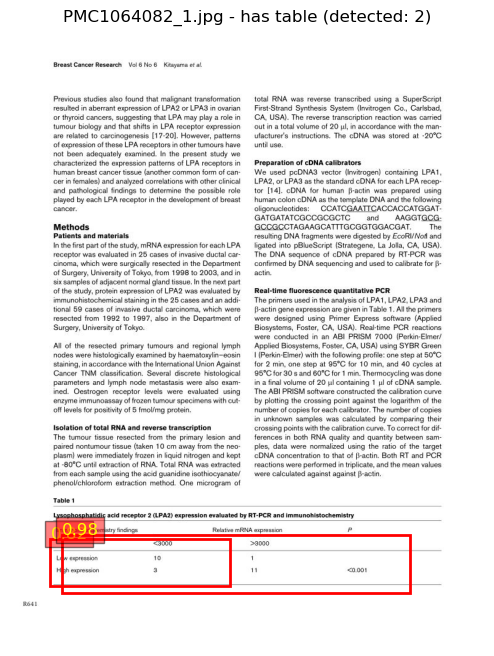

has table (detections above threshold: 2)

Results for PMC1064082_4.jpg:
Total boxes: 15
Scores: [1.0636718e-04 3.2340101e-04 3.1373577e-04 3.6847318e-04 3.2814856e-05
 2.3710165e-04 5.7484891e-04 5.4734722e-02 9.5783710e-01 4.6467128e-05
 2.5512336e-06 5.1954248e-05 5.3397194e-05 6.7647911e-06 1.0057507e-05]
Boxes: [[ 78.08598  380.9468   697.18677  680.3697  ]
 [378.52805  192.21786  693.8449   657.78595 ]
 [384.97064  390.6439   708.2933   676.9511  ]
 [ 88.953735 666.4176   380.2285   795.7681  ]
 [104.460724 514.9664   663.17523  684.09503 ]
 [ 78.965    187.91493  692.2092   729.3707  ]
 [ 66.0001   319.0726   377.7326   662.9402  ]
 [ 59.443485 148.74486  413.8378   663.5568  ]
 [ 68.94739  142.29709  687.94446  668.2441  ]
 [ 84.4571   322.7264   686.18134  674.0192  ]
 [299.33118  508.21436  654.50134  686.14874 ]
 [ 90.25515  376.59686  497.10345  650.4725  ]
 [364.7594   483.38943  701.49536  681.8145  ]
 [106.985664 532.95135  635.6798   727.0366  ]
 [298.37708  319.07922  

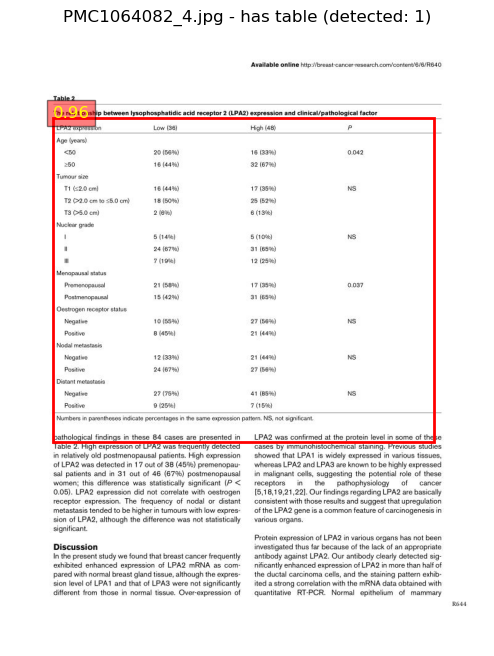

has table (detections above threshold: 1)

Results for PMC1064098_6.jpg:
Total boxes: 15
Scores: [8.5819687e-05 1.6468781e-03 1.0998222e-03 3.9051473e-04 1.4764938e-05
 5.0897844e-04 9.6310051e-03 9.1608623e-03 9.9439162e-01 8.1957449e-05
 1.0906583e-05 9.6327938e-05 9.1058799e-05 4.5401302e-06 4.1185482e-05]
Boxes: [[ 93.69737 462.34918 699.1826  627.5612 ]
 [380.22012 203.60747 704.8605  414.20755]
 [385.31442 468.33987 717.1921  617.42645]
 [ 97.28087 687.6202  382.94406 793.835  ]
 [131.22774 548.04816 654.4368  676.05365]
 [ 77.48053 296.54373 701.8836  579.13965]
 [ 69.36013 426.01965 362.71838 573.6874 ]
 [ 71.29871 194.86021 389.11728 405.54965]
 [ 71.20564 136.05905 702.05664 379.25546]
 [ 91.29677 400.85132 691.80066 579.9018 ]
 [355.32556 587.97784 671.8596  707.6171 ]
 [119.58087 463.81567 515.2118  604.22253]
 [370.71967 571.70605 704.0361  684.6431 ]
 [147.58633 608.7184  636.9923  742.41064]
 [339.20236 407.1769  701.4261  591.08093]]
Detection score: 0.000 for box: [ 93

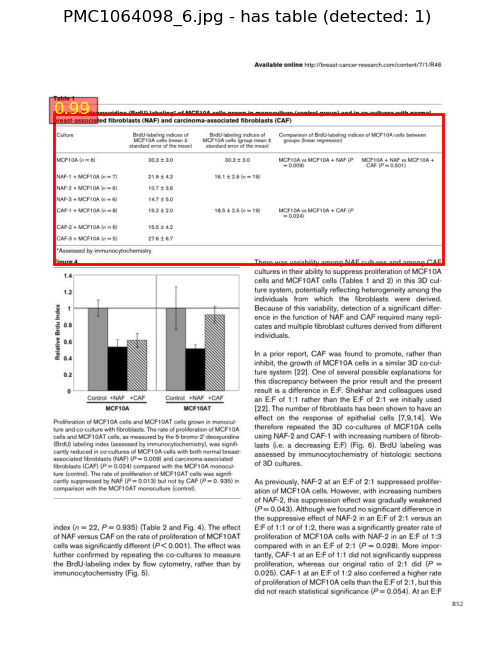

has table (detections above threshold: 1)

Results for PMC1064098_7.jpg:
Total boxes: 15
Scores: [1.2430025e-04 2.2247275e-03 4.9540866e-03 2.3983364e-04 2.6099111e-05
 6.1323168e-04 6.3000703e-03 2.6371447e-02 9.7416604e-01 1.7036503e-04
 2.5312824e-05 1.1990015e-04 1.9480757e-04 6.8326631e-06 9.4783478e-05]
Boxes: [[ 92.36438  468.4085   699.68195  634.16626 ]
 [378.581    210.65125  702.44904  434.3753  ]
 [389.65036  470.42035  717.9349   628.1922  ]
 [ 98.0477   660.0784   383.48663  772.39453 ]
 [130.38762  551.135    656.1067   677.608   ]
 [ 77.18492  298.49924  702.7703   591.3851  ]
 [ 71.122826 428.6836   364.99768  580.71216 ]
 [ 68.40913  179.83153  382.50684  397.60974 ]
 [ 70.66556  139.55135  702.25916  394.5949  ]
 [ 87.50018  404.809    695.2981   586.7255  ]
 [356.695    577.3745   673.8704   700.3431  ]
 [121.22111  469.64166  574.3372   609.28235 ]
 [375.16208  569.6158   707.19214  683.7853  ]
 [138.90427  597.14435  632.70844  731.7884  ]
 [340.39853  409.27365  

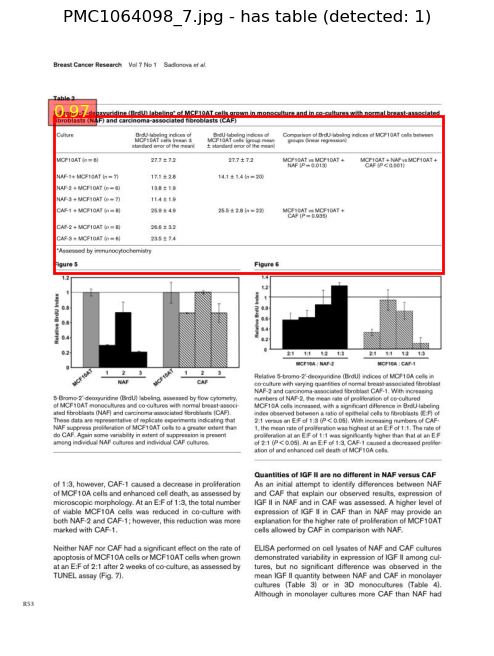

has table (detections above threshold: 1)

Results for PMC1064098_8.jpg:
Total boxes: 15
Scores: [7.9598790e-03 5.2530798e-03 4.1349535e-03 4.0791966e-02 2.5653573e-02
 1.5612647e-02 1.4468154e-04 5.9820112e-04 9.9068308e-01 5.8023124e-03
 3.1755664e-03 9.1418680e-03 1.4992783e-02 9.9592823e-01 1.4464132e-03]
Boxes: [[ 60.981033 432.78333  715.0686   790.13763 ]
 [330.3993   127.188835 703.3503   651.7558  ]
 [376.89307  450.505    718.02637  803.91895 ]
 [ 68.46772  698.0287   402.4183   876.9008  ]
 [ 73.996666 586.30676  709.40656  833.6621  ]
 [ 64.28275  188.82355  706.1096   837.09204 ]
 [ 74.241005 415.92584  542.2894   728.46735 ]
 [ 73.34933  170.02205  417.81137  665.7302  ]
 [ 73.15279  133.2483   698.0621   660.7784  ]
 [ 64.3061   349.33734  713.29926  740.12946 ]
 [ 85.9761   557.0163   696.7503   793.56476 ]
 [ 69.502686 536.8309   694.51697  804.7002  ]
 [280.08533  685.0003   703.06647  895.43774 ]
 [ 79.54966  674.77374  689.04266  912.69275 ]
 [235.98581  238.30852  

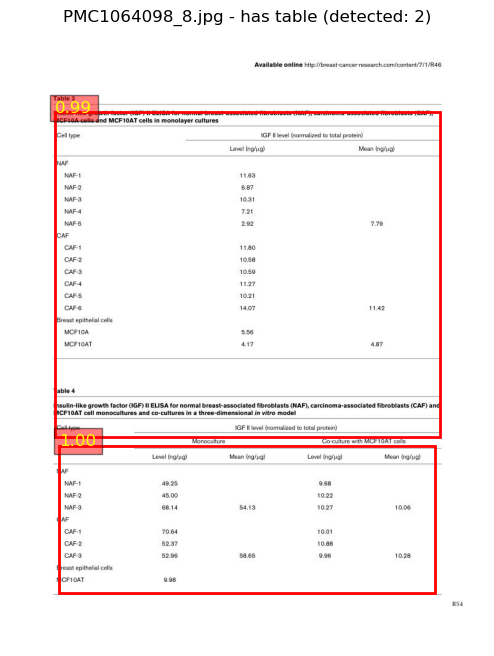

has table (detections above threshold: 2)

Results for hastable.png:
Total boxes: 15
Scores: [1.1455800e-03 3.8278915e-03 5.4673990e-03 3.0244153e-03 6.0962531e-04
 1.2653909e-02 2.9151919e-03 1.0266182e-02 9.1939896e-01 4.3587876e-04
 1.3552075e-04 3.9917111e-04 3.4591049e-04 1.9686730e-04 9.4343850e-04]
Boxes: [[ 213.99011    48.747337 1088.2302    458.755   ]
 [ 671.97577    54.126396 1173.9296    446.28885 ]
 [ 671.8351     56.04104  1151.956     451.90604 ]
 [ 232.07983    41.521244  694.32635   452.0622  ]
 [ 251.97427    51.52604  1023.70105   460.06393 ]
 [ 188.97932    46.212143 1109.1567    456.5969  ]
 [ 234.65771    36.47481   761.381     450.6893  ]
 [ 220.55244    39.193317  736.5823    448.6504  ]
 [ 194.30162    41.021694 1160.6665    442.25653 ]
 [ 213.56389    45.218693 1058.0596    450.46512 ]
 [ 396.46365    45.41718  1030.566     455.51233 ]
 [ 253.2925     43.4868    976.8327    456.8055  ]
 [ 642.4928     54.406296 1107.7689    453.41183 ]
 [ 276.66864    55.5151

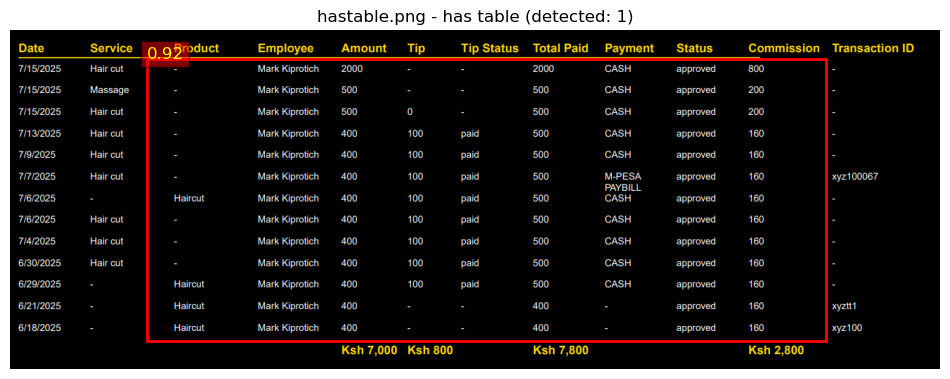

has table (detections above threshold: 1)

Results for notable.png:
Total boxes: 15
Scores: [1.3613807e-04 4.1515374e-01 1.1015901e-03 9.2075643e-04 4.6893177e-04
 2.3708766e-05 3.8142439e-03 3.8534388e-02 1.0744857e-01 1.7378399e-05
 5.6385870e-05 5.5013097e-05 3.7146136e-04 5.4347556e-04 1.1614116e-03]
Boxes: [[272.55893  145.05106  482.42554  169.74245 ]
 [323.8956    31.860903 549.49335   55.563534]
 [326.6291   111.315796 548.0703   136.8607  ]
 [180.58664  286.60306  380.7525   311.3975  ]
 [230.52077  261.5839   419.5961   284.0395  ]
 [213.36575   63.568775 461.54117   97.46762 ]
 [192.19525  157.12553  377.5726   178.1926  ]
 [ 90.62847   39.732544 308.16696   60.42225 ]
 [183.44908   21.320896 466.39145   48.49611 ]
 [271.43924  134.10625  491.49036  163.77328 ]
 [289.4062   223.36047  501.2993   247.44241 ]
 [202.57462  142.12329  396.83322  166.71545 ]
 [295.22638  252.5253   514.8713   274.83408 ]
 [228.33748  282.77844  417.6562   306.53836 ]
 [324.87088   64.56578  531.9

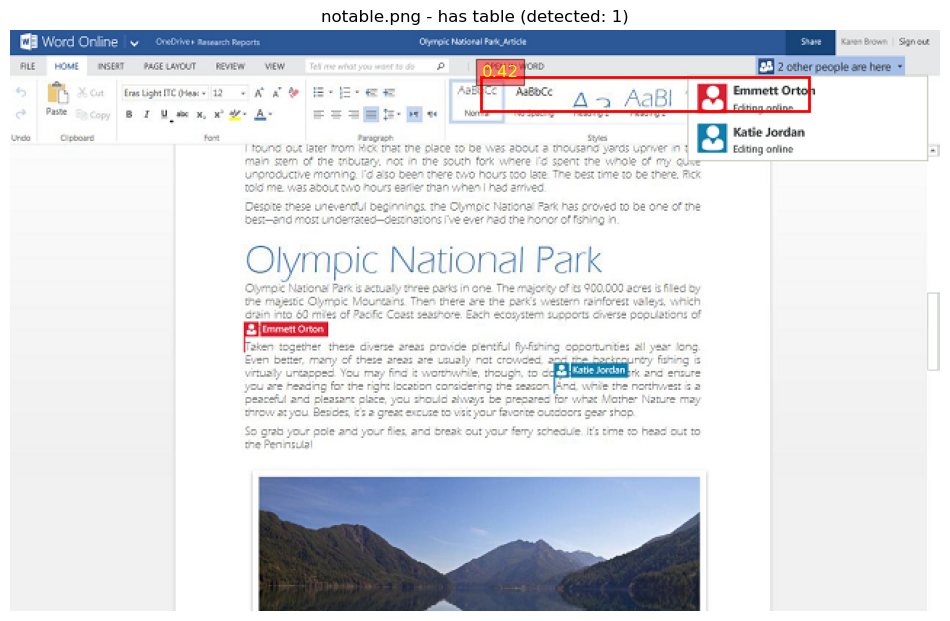

has table (detections above threshold: 1)


In [1]:
import sys
import os
import torch
import json
import argparse

# Add table-transformer/detr to sys.path if not installed as a package
sys.path.append(os.path.join(os.getcwd(), 'table-transformer', 'detr'))

from models import build_model
from datasets.coco import build as build_coco_dataset
from engine import evaluate
import util.misc as utils
from datasets.coco import make_coco_transforms

# Load config
config_path = os.path.join(os.getcwd(), 'table-transformer', 'src', 'detection_config.json')
with open(config_path, 'r') as f:
    config_dict = json.load(f)
config = argparse.Namespace(**config_dict)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Build model
model, criterion, postprocessors = build_model(config)
model.to(device)

# Load saved weights
checkpoint_path = os.path.join(os.getcwd(), 'archive', 'split', 'output', 'model_final.pth')  # or 'final_model.pth'
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model'] if 'model' in checkpoint else checkpoint)

# Preprocess and run inference on sample images in 'samples' directory
import glob
from PIL import Image

samples_dir = os.path.join(os.getcwd(), 'samples')
sample_images = glob.glob(os.path.join(samples_dir, "*.jpg")) + glob.glob(os.path.join(samples_dir, "*.png"))

if not sample_images:
    print(f"No sample images found in '{samples_dir}'. Please add images to proceed.")
    exit(1)

transform = make_coco_transforms("val")

for img_path in sample_images:
    orig_image = Image.open(img_path).convert("RGB")
    img, _ = transform(orig_image, None)
    img_tensor = img.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        results = postprocessors["bbox"](outputs, torch.tensor([orig_image.size[::-1]], device=device))[0]

    # Print detection results for this image
    boxes = results["boxes"].cpu().numpy()
    scores = results["scores"].cpu().numpy()
    print(f"\nResults for {os.path.basename(img_path)}:")
    print(f"Total boxes: {len(boxes)}")
    print(f"Scores: {scores}")
    print(f"Boxes: {boxes}")

    # Visualize detections
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(orig_image)
    has_table = False
    # Set detection threshold
    threshold = 0.3  # Lowered from 0.5 for more sensitivity; adjust as needed

    detected_count = 0
    for box, score in zip(boxes, scores):
        print(f"Detection score: {score:.3f} for box: {box}")  # Debug: print all scores
        if score >= threshold:
            has_table = True
            detected_count += 1
            x0, y0, x1, y1 = box
            rect = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, linewidth=2, edgecolor="r", facecolor="none")
            ax.add_patch(rect)
            ax.text(x0, y0, f"{score:.2f}", color="yellow", fontsize=12, bbox=dict(facecolor="red", alpha=0.5))
    plt.axis("off")
    plt.title(f"{os.path.basename(img_path)} - {'has table' if has_table else 'has no table'} (detected: {detected_count})")
    plt.show()

    # Print has table/has no table message
    if has_table:
        print(f"has table (detections above threshold: {detected_count})")
    else:
        print("has no table (all scores below threshold)")
